In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [30]:
df_default <- read_excel('data/default-cc-data.xls')  %>%
    select(-c(X2:X11))%>%
    rename(client_id = "...1", 
           limit_bal = X1,
           sep_bill = X12 , 
           aug_bill= X13 ,
           july_bill= X14,
           june_bill= X15,
           may_bill= X16, 
           april_bill=X17,
           sep_paid= X18 ,
           aug_paid= X19, 
           july_paid= X20, 
           june_paid= X21 ,
           may_paid= X22 ,
           april_paid= X23,
           default_status = Y)%>%
    slice(2:30001) %>%
    mutate_if(is.character, as.numeric) %>%
    mutate(client_id = as.character(client_id),
          default_status = case_when(default_status =="1"~"yes",
                                     default_status== "0"~"no"),
          default_status = as.factor(default_status),
           apr_debt_ratio = april_bill/limit_bal,
           may_debt_ratio = may_bill/limit_bal,
           jun_debt_ratio = june_bill/limit_bal,
           jul_debt_ratio = july_bill/limit_bal,
           aug_debt_ratio = aug_bill/limit_bal,
           sep_debt_ratio = sep_bill/limit_bal) %>%
    select(client_id, limit_bal, default_status, sep_debt_ratio : apr_debt_ratio)

head(df_default)

New names:
* `` -> ...1



client_id,limit_bal,default_status,sep_debt_ratio,aug_debt_ratio,jul_debt_ratio,jun_debt_ratio,may_debt_ratio,apr_debt_ratio
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,yes,0.1956500,0.1551000,0.0344500,0.00000000,0.00000000,0.0000000
2,120000,yes,0.0223500,0.0143750,0.0223500,0.02726667,0.02879167,0.0271750
3,90000,no,0.3248778,0.1558556,0.1506556,0.15923333,0.16608889,0.1727667
4,50000,no,0.9398000,0.9646600,0.9858200,0.56628000,0.57918000,0.5909400
5,50000,no,0.1723400,0.1134000,0.7167000,0.41880000,0.38292000,0.3826200
6,50000,no,1.2880000,1.1413800,1.1521600,0.38788000,0.39238000,0.4004800


In [37]:
ratio_averages = df_default %>%
    group_by(default_status) %>%
    summarize(apr_avg = mean(apr_debt_ratio),
              may_avg = mean(may_debt_ratio),
              may_avg = mean(may_debt_ratio),
              jun_avg = mean(jun_debt_ratio),
              jul_avg = mean(jul_debt_ratio),
              aug_avg = mean(aug_debt_ratio),
              sep_avg = mean(sep_debt_ratio)) %>%
    pivot_longer(cols = apr_avg:sep_avg,
                 names_to = "Month",
                 values_to = "avg_debt_ratio")
ratio_averages

`summarise()` ungrouping output (override with `.groups` argument)



default_status,Month,avg_debt_ratio
<fct>,<chr>,<dbl>
no,apr_avg,0.2958815
no,may_avg,0.3108478
no,jun_avg,0.3367254
no,jul_avg,0.3702399
no,aug_avg,0.3897752
no,sep_avg,0.4048764
yes,apr_avg,0.3985191
yes,may_avg,0.4114814
yes,jun_avg,0.4396978


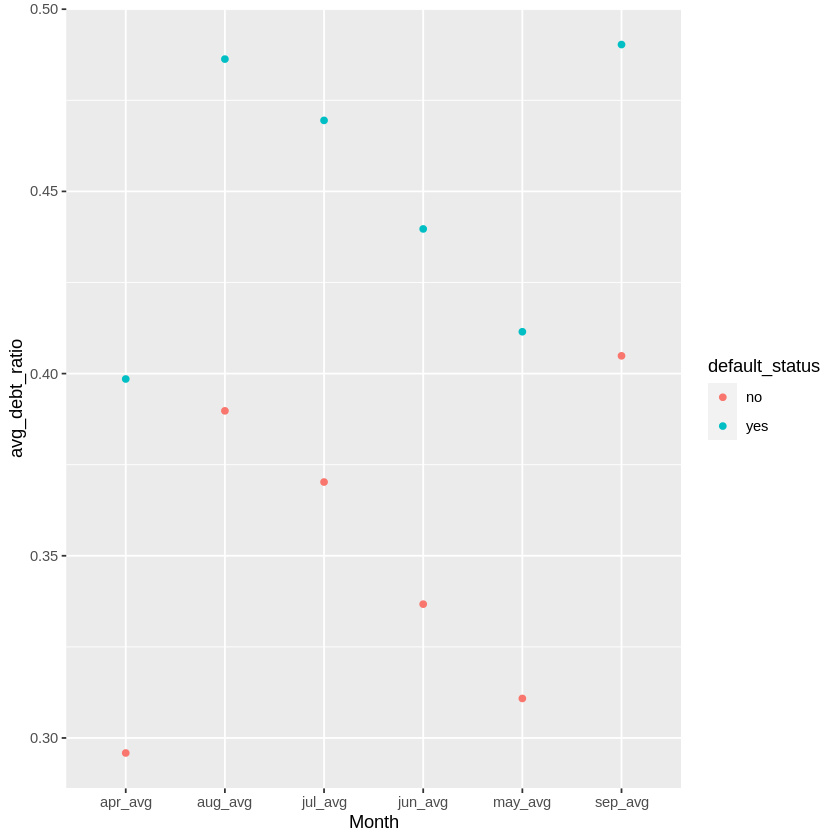

In [38]:
debt_ratio_plot = ratio_averages %>%
    ggplot(aes(x=Month, y=avg_debt_ratio, color=default_status)) +
    geom_point()
debt_ratio_plot

In [26]:
defaulters = df_default %>%
    filter(default_status == "yes")
hist(defaulters$limit_bal)

onTimers = df_default %>%
    filter(default_status == "no")
hist(onTimers$limit_bal)

ERROR: Error in parse(text = x, srcfile = src): <text>:13:0: unexpected end of input
11: # debt_ratio_plot = df_default %>%
12: #     ggplot(aes())
   ^


In [14]:
debt_split = initial_split(df_default, prop = 0.75, strata = default_status)
debt_train = training(debt_split)
debt_test = testing(debt_split)

debt_recipe = recipe(default_status ~ sep_debt_ratio + aug_debt_ratio 
                     + jul_debt_ratio + may_debt_ratio + apr_debt_ratio, data = debt_train)
#             %>%
#               step_upsample(default_status, over_ratio = 1, skip = FALSE) %>%
#               prep()
# I tried applying an upsample to the data to see if I could improve accuracy, but it actually lowered it. 

debt_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# TODO: Commenting out so it doesn't take forever to run every time I reopen Jupyter. Make sure to uncomment for final version
# debt_vfold = vfold_cv(debt_train, v=5, strata = default_status)

# gridvals = tibble(neighbors = seq(1, 200, by=10))

# debt_results = workflow() %>%
#     add_recipe(debt_recipe) %>%
#     add_model(debt_spec) %>%
#     tune_grid(resamples = debt_vfold, grid = gridvals)%>%
#     collect_metrics()
# debt_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
100,accuracy,binary,0.7783111,5,1.351442e-04,Model01
100,roc_auc,binary,0.6379625,5,4.141502e-03,Model01
110,accuracy,binary,0.7789334,5,4.053984e-04,Model02
110,roc_auc,binary,0.6376950,5,4.283369e-03,Model02
120,accuracy,binary,0.7786667,5,2.364968e-04,Model03
120,roc_auc,binary,0.6383053,5,4.098881e-03,Model03
130,accuracy,binary,0.7786223,5,1.563211e-04,Model04
130,roc_auc,binary,0.6382663,5,3.985251e-03,Model04
140,accuracy,binary,0.7786667,5,2.013944e-04,Model05


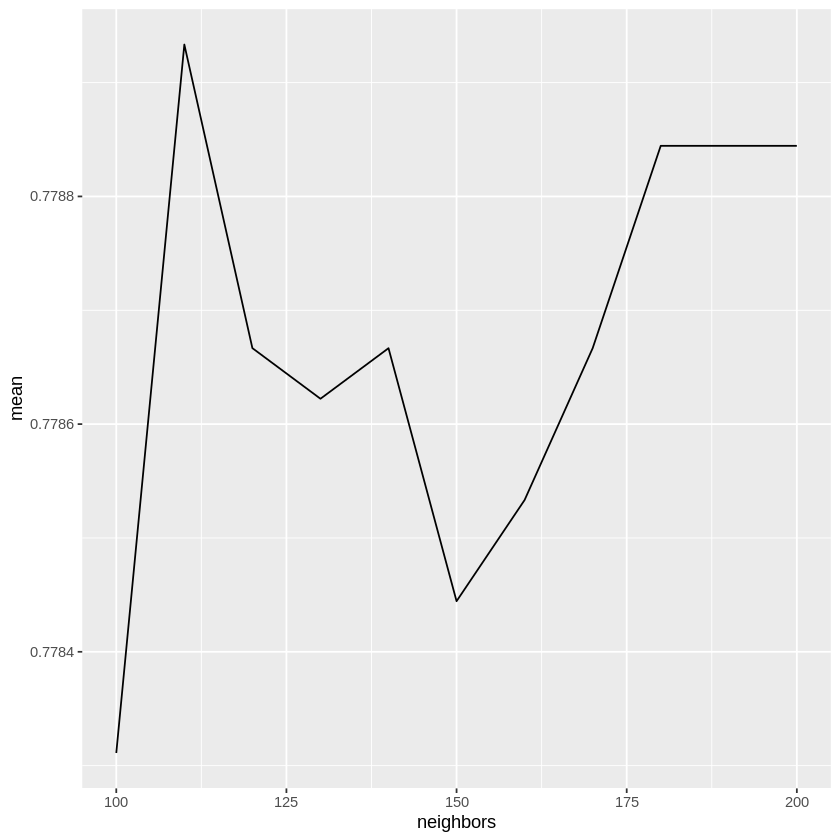

In [15]:
vfold_plot = debt_results %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x=neighbors, y=mean)) +
    geom_line()
vfold_plot


In [22]:
final_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 100) %>%
    set_engine("kknn") %>%
    set_mode("classification")

final_fit = workflow() %>%
    add_recipe(debt_recipe) %>%
    add_model(final_spec) %>%
    fit(data = debt_train)
final_fit

debt_test_predictions = predict(final_fit, debt_test) %>%
    bind_cols(debt_test)
debt_test_predictions

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~100, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2216889
Best kernel: rectangular
Best k: 100

.pred_class,client_id,limit_bal,default_status,sep_debt_ratio,aug_debt_ratio,jul_debt_ratio,may_debt_ratio,apr_debt_ratio
<fct>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,1,20000,yes,0.1956500000,0.1551000000,0.0344500000,0.0000000000,0.0000000000
no,4,50000,no,0.9398000000,0.9646600000,0.9858200000,0.5791800000,0.5909400000
no,6,50000,no,1.2880000000,1.1413800000,1.1521600000,0.3923800000,0.4004800000
no,8,100000,no,0.1187600000,0.0038000000,0.0060100000,-0.0015900000,0.0056700000
no,10,20000,no,0.0000000000,0.0000000000,0.0000000000,0.6503500000,0.6956000000
no,14,70000,yes,0.9400285714,0.9624142857,0.9385857143,0.5162428571,0.5270571429
no,15,250000,no,0.2835480000,0.2682400000,0.2542440000,0.2275000000,0.2220480000
no,18,320000,no,0.7915187500,0.7704250000,0.6083218750,0.0183000000,0.6112468750
no,19,360000,no,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [23]:
accuracy = debt_test_predictions %>%
    metrics(truth = default_status, estimate = .pred_class) 

confidence = debt_test_predictions %>%
    conf_mat(truth = default_status, estimate = .pred_class)

accuracy
confidence

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.777200000
kap,binary,0.006128576


          Truth
Prediction   no  yes
       no  5815 1645
       yes   26   14

In [ ]:
test
